
# Project Milestone One: Forming Your Team, Understanding the Problem, and Exploring the Data

#### **Due:** Midnight on October 26th (with 2-hour grace period) — **worth 25 points**

> **Note:** Because we must begin manual grading immediately, there will be *no* late period for this milestone.

This milestone is the first phase of your project. You’ll begin working in teams, select your dataset, perform basic exploratory data analysis (EDA), and frame your classification problem.  

1. **Form your project team.**  
   Convene your team and complete the **Team Contract** (available in your Homework Repository). This is **due on Sunday, October 19th** at midnight (along with Homework 07). Each member must review and sign it before submission.

2. **Select a team leader.**  
   Choose one team member to act as the **Gradescope submitter** for your team. The entire team should collaborate on the notebook, but only the leader will submit.

3. **Explore your dataset and frame your task.**  
   You’ll work through the notebook to  
   - Examine both provided datasets,  
   - Choose one for your project,
   - Be able to describe the classification problem you’ll be solving in business or applied terms,
   - Conduct basic EDA to understand its structure and challenges, and
   - Spot potential challenges, propose solutions, and select appropriate performance metrics.  

This milestone focuses on understanding your data and clearly articulating what your model will eventually predict. You are not required to build a model yet (that will happen in Milestone 2) but of course you have lots of example models to choose from previous Homeworks and Coding Notebooks and you may wish to explore a baseline model as you do this first phase of your project.


### The Datasets

The final project is a **classification task** using **one of two datasets**—one image-based and one text-based. These are the two
domains we have studied in detail, after learning the fundamentals in the first three weeks, and you have all you need to approach either of these datasets with confidence.

#### **1. Food-101 (Images)**  
A web-scraped collection of approximately **101,000 color photos** across **101 food categories** (≈ 800 train / 100 validation / 100 test per class).  
Images vary widely in **lighting, composition, and color balance**, making this dataset excellent for practicing **data cleaning**, **EDA**, and **augmentation** techniques such as random crops, flips, and color jitter.

#### **2. HuffPost News Category (Text)**  
Roughly **200,000 short news items** labeled into **41 topical categories** (e.g., *POLITICS*, *ENTERTAINMENT*, *PARENTING*).  
Each record contains a **headline**, a **short description**, which we will concatenate with a separator token to make a single text string:
> `"headline [SEP] short_description"`.
>
The `[SEP]` token simply marks where the headline ends and the description begins—mirroring conventions used in transformer models such as BERT.


### What To Do


We’ve provided template code to start your project:

* **Download** your selected dataset.
* **Visualize** a few representative samples (images or text excerpts).

After reviewing both datasets, you’ll **choose one** for your semester project.

In the sections that follow:

* **Problem One — Exploratory Data Analysis (EDA):**
  Quantify scale and structure, check class balance, and note any missing/duplicate or inconsistent entries.

* **Problem Two — Challenges & Solution Paths:**
  Identify likely issues (e.g., overlapping categories, imbalanced labels, data-quality problems, length/size variance) and outline practical remedies you would try. *(No model training required.)*

For tips on working with **Hugging Face Datasets** (helpful for large datasets), see the **Appendix**.

> **Important:** Keep only the section for the dataset you select and delete the other before submitting **Milestone 1**.


In [2]:
# ============================================
# Useful Imports
# ============================================

# --- Standard Libraries
import os
import time
import math
import random
from collections import Counter

# --- Core Data / Numerics
import numpy as np
import pandas as pd

# --- Visualization
import matplotlib.pyplot as plt
# import seaborn as sns              # optional
import matplotlib.ticker as mticker  # optional (for formatted axes)

# --- NLP / Tokenization
import spacy                         # used for text preprocessing (HuffPost)

# --- Progress Tracking
from tqdm import tqdm                # optional (nice for loops)

from IPython.display import display

# --- TensorFlow / Keras (Deep Learning)
import tensorflow as tf
from tensorflow.keras import layers, models, Input, callbacks, regularizers, initializers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, MaxPooling2D, Conv2D,
    SeparableConv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
)

# --- (Optional) Classical ML Baseline Tools
# from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score


# ============================================
# Global Configuration & Small Utilities
# ============================================

# Reproducibility
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)   # sets Python, NumPy, and TensorFlow seeds

# Utility: format seconds as HH:MM:SS

"""
Example usage to time your code:

start_time = time.time()
# ... your code here ...
print("Execution Time:", format_hms(time.time() - start_time))
"""

def format_hms(seconds: float) -> str:
    """Convert seconds to HH:MM:SS format."""
    return time.strftime("%H:%M:%S", time.gmtime(seconds))


In [ ]:
# If needed (in a new env):
# !pip install -U datasets pillow

In [3]:
# --- Hugging Face Datasets
from datasets import load_dataset, DatasetDict
from datasets.features import ClassLabel

## Prelude: Choose your dataset and take a first look

You’ll pick **one** dataset—either **Food-101 (images)** or **HuffPost (text)**—and run the starter cells to confirm it loads, view class stats, and skim a few samples.

* **Food-101 (images):** 101 classes of web photos with **inconsistent lighting, white balance, color casts, and composition** (plus varying resolutions). These natural quirks make augmentation and input-pipeline choices meaningful.
* **HuffPost (text):** ~200k headline/summary pairs across 41 topics with **class imbalance** and some **category overlap**—good for trying stratified splits and reporting macro-F1 in addition to accuracy.

After you review the two sections below (download → minimal EDA → split), **keep one and delete the other.** Stick with your choice for the entire project.

> **Note:** We use Hugging Face **Dataset/DatasetDict** objects (table-like datasets), not NumPy/Pandas arrays. Most of what you need to know is contained in the template code, but see the **Appendix** for more information on HG Datasets.


---

### Dataset Two (Text): HuffPost Dataset

#### **Load HuffPost (headline + summary + category)**

**Note:** This loads a **Hugging Face `Dataset`**, not a NumPy array or Pandas DataFrame.
- Each record is a **dictionary** with fields such as `"headline"`, `"short_description"`, and `"category"`.
- You can access columns by name (e.g., `huff["headline"]`) and check dataset size with `len(huff)`.
- Treat it as a table of text fields — you’ll handle tokenization and vectorization later during preprocessing.
- The typical BERT-compatible separator is used to construct the sample texts

        `headline [SEP] short-description`



In [4]:
# JSON mirror that preserves fields: headline, short_description, category, authors, link, date
URL = "https://huggingface.co/datasets/khalidalt/HuffPost/resolve/main/News_Category_Dataset_v2.json"
huff_all = load_dataset("json", data_files=URL, split="train")

print(huff_all)
print("Columns:", huff_all.column_names)
print("Total rows:", len(huff_all))

Dataset({
    features: ['category', 'headline', 'authors', 'link', 'short_description', 'date'],
    num_rows: 200853
})
Columns: ['category', 'headline', 'authors', 'link', 'short_description', 'date']
Total rows: 200853


#### **Quick sanity checks (peek at a row)**

In [5]:
ex = huff_all[0]
print("One example:")
print("  category          :", ex.get("category"))
print("  headline          :", (ex.get("headline") or "")[:120])
print("  authors           :", (ex.get("authors") or "")[:120])
print("  short_description :", (ex.get("short_description") or "")[:120])
print("  date              :", ex.get("date"))

One example:
  category          : CRIME
  headline          : There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV
  authors           : Melissa Jeltsen
  short_description : She left her husband. He killed their children. Just another day in America.
  date              : 2018-05-26 00:00:00


In [6]:
ex.keys()

dict_keys(['category', 'headline', 'authors', 'link', 'short_description', 'date'])

#### **Print 10 random samples (combined text with separator, no truncation)**

In [7]:
# Show k random lines: "headline [SEP] short_description"

k = 10
seed = 7
rng = random.Random(seed)
idxs = rng.sample(range(len(huff_all)), k)

for i in idxs:
    ex = huff_all[i]
    print("  category          :", ex.get("category"))
    print("  headline          :", (ex.get("headline") or ""))
    print("  short_description :", (ex.get("short_description") or ""))
    print("  sample text       :", (ex.get("headline") or "")+'  [SEP]  '+ (ex.get("short_description") or ""))
    print()

  category          : ENTERTAINMENT
  headline          : Pregnant Kim Kardashian Rocks A Sheer Jumpsuit At The Airport
  short_description : Forget what you thought you knew about maternity style, because Kim's changing the game.
  sample text       : Pregnant Kim Kardashian Rocks A Sheer Jumpsuit At The Airport  [SEP]  Forget what you thought you knew about maternity style, because Kim's changing the game.

  category          : WOMEN
  headline          : How I Outran Misogyny
  short_description : "I have started running to retrain the way my brain sees my body, not as a sexual object but as a tool to get things done."
  sample text       : How I Outran Misogyny  [SEP]  "I have started running to retrain the way my brain sees my body, not as a sexual object but as a tool to get things done."

  category          : RELIGION
  headline          : A Prayer From the Mall of America
  short_description : I thank you for the Bloomington Police Department, and the Mall of America Security

#### **(Optional) Save splits to disk (reload later without re-splitting)**

We provide this in case you want to save the dataset to your local disk. Saving Food-101 splits to disk is not recommended unless you have ample local storage (it's huge!).

In [ ]:
# huff.save_to_disk("huffpost_splits")        # save
# from datasets import load_from_disk
# huff = load_from_disk("huffpost_splits")  # reload when needed

---

## Problem 1 – Choose the Dataset (10 pts)

#### Objective
In this problem, you will explore the two provided datasets and select one to use for your final project.  
Your goal is to understand the structure, content, and challenges of the dataset through basic exploratory data analysis (EDA).  
By the end of this Milestone notebook, you should be able to explain what makes the dataset interesting, identify potential modeling challenges (e.g., imbalance, ambiguity, quality issues), and justify why it is a good choice for your classification project.


#### What to Do
1. **Load both datasets** and examine the outputs of the template code provided.  
   After this brief inspection, **choose one dataset for your project** and **delete the template code for the other.**  For your chosen dataset, continue with the remaining steps.

2. **Inspect** the dataset's basic properties:  
   - **Number of samples and classes:**  
     Determine how many total examples and distinct categories are present. Verify that the counts match expectations (e.g., 101 food classes or 41 news topics).  
   - **Example records or images:**  
     View several samples to understand the input format, diversity, and potential quality issues.  
     For images, note lighting or composition differences; for text, read a few headlines and summaries to see how expressive they are (done for you in template code).
   - **Distribution of labels (check for imbalance):**  
     Plot or tabulate label frequencies to see whether some classes dominate. Imbalanced datasets can bias model training and may require special handling.  
   - **Missing or inconsistent data:**  
     Look for empty fields, unreadable images, duplicate entries, or mislabeled samples. Handle or document any issues you find.  
   - **Overlapping or ambiguous class labels:**  
     Identify categories that may not be clearly distinct—e.g., “apple pie” vs. “cheesecake,” or “POLITICS” vs. “WORLD NEWS.”  
     Ambiguity in labels can increase confusion between classes and reduce model accuracy.

3. **Visualize key aspects:**  
   Extend the template code to complete the EDA for your chosen dataset:  
   - **Images:**  
     Create visual summaries to better understand the data (some are implemented in the template code).  
     - Verify that the dataset is balanced across classes.  
     - Display a small grid of random images to check variation in appearance, composition, and background (done in template code).  
     - Compare image sizes to determine whether resizing or normalization will be needed.  
     - Examine lighting and color balance—many web-scraped photos vary widely in brightness, saturation, and white balance.  
   - **Text:**  
     Visualize class balance and linguistic properties (some implemented in the template code).  
     - Plot the number of samples per label to confirm class balance or imbalance.  
     - Compute basic text statistics such as average word count or vocabulary size.  
     - Examine examples for duplicates, near-duplicates, or entries that might fit multiple categories.  
     - *(Optional)* Generate a word-frequency plot or word cloud to highlight distinctive terms for a few classes.

4. **Answer the graded questions below.**


**Dataset Choice:** We briefly inspected both datasets and selected **HuffPost (text)** for our project. It allows faster iteration on CPU, has clearer EDA and interpretability, and its class imbalance makes it better suited for stratified splits and macro-F1 evaluation. In accordance with the assignment instructions, the Food-101 cells were removed after inspection.


In [8]:
# =========================================================
# Number of samples and classes
# =========================================================

# We confirm expected columns exist.
required = {"headline", "short_description", "category"}
assert required.issubset(set(huff_all.column_names)), f"Missing: {required - set(huff_all.column_names)}"

n_rows = len(huff_all)
class_counts = Counter(huff_all["category"])
n_classes = len(class_counts)

print(f"Total samples: {n_rows}")
print(f"Distinct classes: {n_classes}")

# Show a compact table of the 10 largest and 10 smallest classes
cc = pd.Series(class_counts).sort_values(ascending=False)
display(cc.head(10).rename("count").to_frame())
display(cc.tail(10).rename("count").to_frame())




Total samples: 200853
Distinct classes: 41


,count
POLITICS,32739
WELLNESS,17827
ENTERTAINMENT,16058
TRAVEL,9887
STYLE & BEAUTY,9649
PARENTING,8677
HEALTHY LIVING,6694
QUEER VOICES,6314
FOOD & DRINK,6226
BUSINESS,5937


,count
MONEY,1707
ARTS,1509
FIFTY,1401
GOOD NEWS,1398
ARTS & CULTURE,1339
ENVIRONMENT,1323
COLLEGE,1144
LATINO VOICES,1129
CULTURE & ARTS,1030
EDUCATION,1004


In [9]:
# =========================================================
# Example records or images (Text version in our case)
# =========================================================
# We create a combined text field as specified: headline [SEP] short_description,
# and print a small sample to understand expressiveness and potential issues.

def make_text(ex):
    h = (ex["headline"] or "").strip()
    d = (ex["short_description"] or "").strip()
    ex["text"] = f"{h} [SEP] {d}".strip()
    return ex

huff = huff_all.map(make_text)

k = 5
seed = 42
rng = random.Random(seed)
idxs = rng.sample(range(len(huff)), k)

for i in idxs:
    ex = huff[i]
    print(f"[{ex['category']}] {ex['text']}\n")


[STYLE & BEAUTY] Katy Perry Wears American Flag Outfit For Kids' Inaugural Concert (PHOTOS) [SEP] Channeling Uncle Sam can actually be pretty cute.

[COMEDY] Stop Asking Brands To Give You Free Stuff For Retweets [SEP] Don’t give multimillion-dollar businesses free advertising!

[POLITICS] In Era Of Donald Trump, Bernie Sanders Sees ‘The Beginning Of A Political Revolution’ [SEP] The Vermont senator’s response to the State of the Union was long, fiery and surprisingly optimistic.

[DIVORCE] What Can Facebook Teach A Stepfamily? [SEP] Did you know that there is no delineation for a stepparent on Facebook?

[PARENTS] Mom Who Lost Son At Sandy Hook: We Can't Accept Gun Violence As 'New Normal' [SEP] "I would turn back time in a moment to have my boy back in my arms, but I can't do that."



Class count summary:
    min  median     mean    max  max/min ratio
0  1004    3405  4898.85  32739          32.61


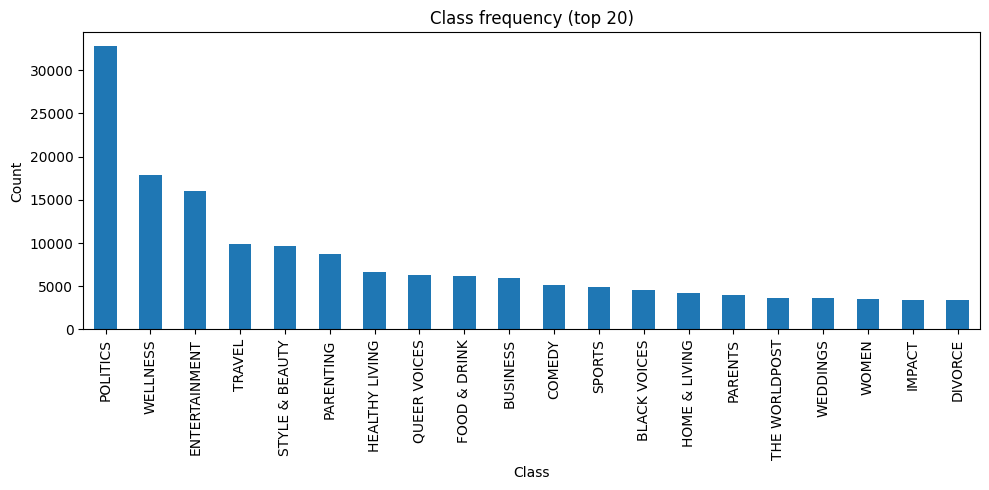

In [10]:
# =========================================================
# Distribution of labels (check for imbalance)
# =========================================================
# We tabulate label frequencies and visualize the top-20 classes.

cc = pd.Series(Counter(huff["category"])).sort_values(ascending=False)
print("Class count summary:")
print(
    pd.DataFrame({
        "min": [int(cc.min())],
        "median": [int(cc.median())],
        "mean": [round(cc.mean(), 2)],
        "max": [int(cc.max())],
        "max/min ratio": [round(cc.max() / cc.min(), 2)]
    })
)

# Bar chart (top 20) to show imbalance
topn = 20
plt.figure(figsize=(10, 5))
cc.head(topn).plot(kind="bar")
plt.title(f"Class frequency (top {topn})")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [10]:
# =========================================================
# Missing or inconsistent data
# =========================================================
# We check empty fields and simple duplicates to document potential issues.

head = pd.Series(huff["headline"]).fillna("").str.strip()
desc = pd.Series(huff["short_description"]).fillna("").str.strip()
text = pd.Series(huff["text"]).fillna("").str.strip()

empty_headline = int((head == "").sum())
empty_desc = int((desc == "").sum())
empty_text = int((text == "").sum())

print("Empty fields:")
print({
    "empty_headline": empty_headline,
    "empty_short_description": empty_desc,
    "empty_combined_text": empty_text
})
print({
    "pct_empty_headline": round(100*empty_headline/len(huff), 3),
    "pct_empty_short_description": round(100*empty_desc/len(huff), 3),
    "pct_empty_combined_text": round(100*empty_text/len(huff), 3),
}, "%")

# Duplicate detection (exact duplicates of (headline, short_description))
pairs = list(zip(head.tolist(), desc.tolist()))
dup_mask = pd.Series(pairs).duplicated(keep=False)
dup_total = int(dup_mask.sum())

print("\nDuplicate pairs (headline, short_description):", dup_total)
print("Percent of dataset duplicated (pair-level):", round(100*dup_total/len(huff), 3), "%")

# Also check duplicate headlines only (sometimes the short_description differs slightly)
dup_headlines = int(head.duplicated(keep=False).sum())
print("Duplicate headlines (any description):", dup_headlines)
print("Percent of dataset with duplicate headlines:", round(100*dup_headlines/len(huff), 3), "%")


Empty fields:
{'empty_headline': 6, 'empty_short_description': 19712, 'empty_combined_text': 0}
{'pct_empty_headline': 0.003, 'pct_empty_short_description': 9.814, 'pct_empty_combined_text': 0.0} %

Duplicate pairs (headline, short_description): 697
Percent of dataset duplicated (pair-level): 0.347 %
Duplicate headlines (any description): 2226
Percent of dataset with duplicate headlines: 1.108 %


In [12]:
# =========================================================
# Overlapping or ambiguous class labels
# =========================================================
# We do a lightweight heuristic: for a few plausible pairs, compare overlap between
# the top keywords (by simple frequency) in each class. High overlap suggests ambiguity.
# This is a quick signal for categories like POLITICS vs WORLD NEWS, or
# ENTERTAINMENT vs ARTS & CULTURE, etc.

from collections import defaultdict
import re

def tokenize(s: str):
    # simple lowercase word tokens
    return re.findall(r"[A-Za-z']+", s.lower())

def top_tokens_for_class(data, label, k=200, sample_per_class=3000, seed=42):
    rng = random.Random(seed)
    idxs = [i for i, c in enumerate(data["category"]) if c == label]
    if len(idxs) > sample_per_class:
        idxs = rng.sample(idxs, sample_per_class)
    counts = Counter()
    for i in idxs:
        counts.update(tokenize(data[i]["text"]))
    # remove very short tokens
    for t in list(counts.keys()):
        if len(t) <= 2:
            del counts[t]
    return set([w for w, _ in counts.most_common(k)])

# We evaluate a small list of likely-overlapping pairs
suspect_pairs = [
    ("POLITICS", "WORLD NEWS"),
    ("ENTERTAINMENT", "ARTS & CULTURE"),
    ("STYLE & BEAUTY", "PARENTING"),
    ("TECH", "SCIENCE"),
]

results = []
for a, b in suspect_pairs:
    A = top_tokens_for_class(huff, a)
    B = top_tokens_for_class(huff, b)
    jaccard = len(A & B) / max(1, len(A | B))
    results.append({"pair": f"{a} vs {b}", "jaccard_overlap": round(jaccard, 3),
                    "shared_examples_of_tokens": list((A & B))[:10]})

pd.DataFrame(results)


,pair,jaccard_overlap,shared_examples_of_tokens
0,POLITICS vs WORLD NEWS,0.384,"[when, she, and, leaders, now, russia, that, w..."
1,ENTERTAINMENT vs ARTS & CULTURE,0.449,"[when, good, she, and, now, 'the, that, says, ..."
2,STYLE & BEAUTY vs PARENTING,0.423,"[when, good, she, and, now, that, week, world,..."
3,TECH vs SCIENCE,0.418,"[when, good, another, and, now, that, week, sa..."


count    200853.00
mean         30.27
std          14.05
min           1.00
50%          29.00
90%          50.00
95%          57.00
99%          68.00
max         246.00
dtype: float64


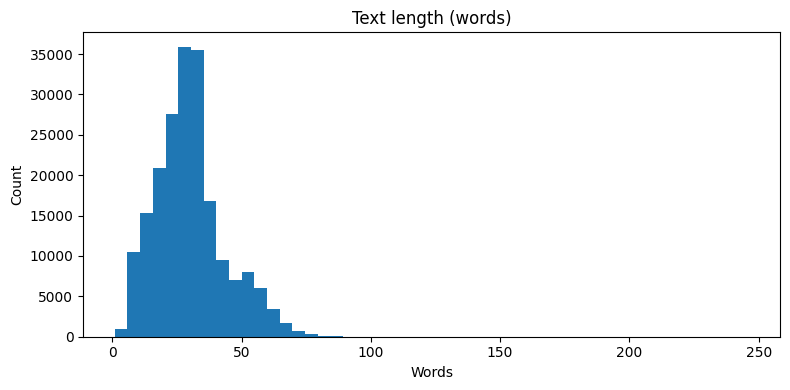

In [13]:
# =========================================================
# Visualize key aspects — word-count distribution
# =========================================================
# We visualize the distribution of text lengths (in words) to understand variance
# and guide later tokenization/truncation decisions.

lengths = pd.Series([len(str(t).split()) for t in huff["text"]])
stats = lengths.describe(percentiles=[.5, .9, .95, .99]).round(2)
print(stats)

plt.figure(figsize=(8, 4))
plt.hist(lengths, bins=50)
plt.title("Text length (words)")
plt.xlabel("Words")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [14]:
# =========================================================
# Word-frequency table with color scaling
# =========================================================
# This gives us a top-20 list of tokens per class and shades them
# by relative frequency (value counts normalized to the most frequent word).
# Visually helpful -> which words dominate the class vocabulary.
import pandas as pd
from collections import Counter
import re

def tokenize_minimal(text):
    return re.findall(r"[A-Za-z']+", str(text).lower())

def top_words_table(label, topn=20):
    # get all text for the given label
    idxs = [i for i, c in enumerate(huff["category"]) if c == label]
    counts = Counter()
    for i in idxs:
        counts.update(tokenize_minimal(huff[i]["text"]))
    # remove short filler tokens
    for t in list(counts.keys()):
        if len(t) <= 2:
            del counts[t]
    # make table
    s = pd.Series(dict(counts.most_common(topn)))
    df = pd.DataFrame({"word": s.index, "count": s.values})
    # normalize (relative to top word)
    df["relative_freq"] = df["count"] / df["count"].max()
    return df

labels_to_view = ["POLITICS", "ENTERTAINMENT"]

tables = {}
for lbl in labels_to_view:
    df = top_words_table(lbl, topn=20)
    print(f"\nTop 20 tokens — {lbl}")
    display(
        df.style.background_gradient(
            subset=["relative_freq"], cmap="Blues"
        ).format({"relative_freq": "{:.2f}"})
    )



Top 20 tokens — POLITICS


,word,count,relative_freq
0,the,40835,1.00
1,sep,32739,0.80
2,and,12362,0.30
3,trump,10585,0.26
4,for,10039,0.25
5,that,6029,0.15
6,with,4642,0.11
7,donald,4363,0.11
8,are,4223,0.10
9,his,3919,0.10



Top 20 tokens — ENTERTAINMENT


,word,count,relative_freq
0,the,16645,1.00
1,sep,16058,0.96
2,and,6657,0.40
3,for,3647,0.22
4,with,2932,0.18
5,that,2068,0.12
6,her,1927,0.12
7,this,1918,0.12
8,you,1876,0.11
9,new,1873,0.11


### Graded Questions (2 pts each)

For each question, answer thoroughly but concisely, in a short paragraph, longer or shorter as needed. Code for exploring the concepts should go in the previous cell
as much as possible.

1. **Dataset Summary:**  
   Describe your chosen dataset  (as if explaining to your *clueless boss* what you are working on).
   - State which dataset you are going to use.   
   - What kind of data does it contain (images or text)?  
   - How many samples and classes are there?  
   - What is the task you’ll perform (classification into what categories)?
   - What is the potential business use for this dataset?

1.1. **Your answer here:**

We are using the HuffPost News Category dataset, which is a large collection of short online news stories from the HuffPost website. Each record contains a headline and a short description, and every story is labeled with one of 41 news topics, such as Politics, Entertainment, Business, or Sports. In total, there are a little over 200,000 news articles.

Our job is to build a system that can automatically guess which topic a news article belongs to, based only on the text. This is a classification problem: given the words in the article, the model must choose the correct category.

From a business perspective, a system like this is useful for organizing large volumes of content automatically, improving search and navigation, helping with personalized recommendations, or even supporting news aggregation platforms that need to filter or tag articles quickly without human editors.



2. **Initial Observations:**  
   What stood out to you from your EDA?  
   - Did you notice any imbalanced or ambiguous classes?  
   - Any patterns, anomalies, or potential sources of bias?  
   - For images: note any variation in lighting, composition, or color.  
   - For text: mention redundancy, topic overlap, or very short examples.

1.2. **Your answer here:**

Our EDA revealed a **strong class imbalance**: the largest category (**POLITICS**) contains over **32,000** entries, while the smallest categories contain around **1,000**. This creates a long-tailed distribution with a **max/min ratio of ~32:1**, meaning that model performance must be evaluated beyond plain accuracy (e.g., macro-F1).  

Roughly **9.8%** of samples contain an **empty short description**, but most still have informative headlines. We also observed **minor redundancy**: around **1.1%** of samples reuse the same headline, and ~0.35% are exact (headline + description) duplicates. Additionally, there is a small tail of **very short texts** (fewer than ~5–10 words), which provide limited context and could be harder for a classifier to interpret. Lastly, text length is generally  moderate (mean ~30 words), so the dataset is well-suited for transformer-based tokenization without excessive truncation.

Finally, several categories show **semantic overlap** (e.g., *POLITICS* vs. *WORLD NEWS*, or *ENTERTAINMENT* vs. *ARTS & CULTURE*), which may introduce ambiguity during training and create confusion boundaries between closely related topics.





3. **Challenges & Implications:**  
   Based on your inspection, what challenges might affect model performance or training (e.g., imbalance, ambiguous labels, variable quality)?  

1.3. **Your answer here:**

The main challenges are (1) **label imbalance**, which can bias prediction toward large classes, and (2) **ambiguous or overlapping topical boundaries**, which may limit the model’s ability to distinguish conceptually similar categories. Missing short descriptions reduce context for a subset of samples but do not prevent classification since headlines still provide signal. These issues imply that careful data handling, stratified splitting, and appropriate evaluation metrics will be necessary to ensure fairness and generalization across low-frequency classes.



4. **Preparation Ideas:**  
   What data-cleaning or preprocessing steps might help address these issues?  
   (You will not implement these yet—just describe what you might do later.)

1.4. **Your answer here:**

Before modeling, we plan to clean the text by normalizing casing, removing obvious duplicates, and handling missing short descriptions by either retaining headline-only entries or imputing a neutral placeholder. To mitigate imbalance, we may use **stratified sampling**, **class weighting**, or **focal loss** during training. If ambiguity remains between conceptually similar categories, we may explore mild hierarchical grouping or topical clustering in later stages. Tokenization and sequence truncation will also be tuned to preserve as much semantic content as possible without unnecessarily increasing model complexity.


5. **Reflection:**  
   Why did you choose this dataset over the other one?  
   - What makes it more interesting, realistic, or relevant for you?  
   - What do you expect to learn from working with it?

1.5. **Your answer here:**

We chose the HuffPost dataset mainly because it is more interesting and engaging for us to work with. Text classification feels closer to real applications we encounter in everyday life (news feeds, topic filtering, recommendation engines), so it is easier to stay motivated. It is also lighter to load and iterate on compared to Food-101, which would have required heavier preprocessing and longer training times due to image size and GPU needs. Since we also recently covered text-based models in class, the workflow is still fresh in our minds. Working with this dataset will help us practice handling class imbalance, designing fair evaluation metrics, and experimenting with tokenization and text preprocessing in a realistic setting.

---


## Problem 2 – Frame the Problem (15 pts)





#### Objective

Identify the **key challenges** in your chosen dataset and outline **practical solutions** you would try, plus how you’ll **evaluate** them later.

#### Steps to follow

1. **Diagnose likely challenges (from your EDA):**

   Examples:
   * **Class imbalance:**
     Report label counts and an imbalance ratio (max / median). List any minority classes.
   * **Length/size variance:**
     For text, show length percentiles (50/75/90/95) and estimate truncation rate at candidate `max_text_length`s (e.g., 256/300/512). For images, summarize native resolutions.
   * **Noise/duplicates/leakage:**
     Note empty or malformed items, near-duplicates, and how you would prevent cross-split leakage.
   * **Ambiguous/overlapping labels:**
     Give 2–3 example pairs you expect to be confusable and why.
   * **Compute constraints:**
     Briefly state limits (RAM/GPU/CPU) that might affect batch size, sequence length, or image size.

2. **Map each challenge to a concrete solution plan:**

   Examples:
   * **Imbalance →** `class_weight` or oversampling; report which one you’d try first and why.
   * **Length/size →** pick a target `max_text_length` (e.g., 95th percentile) with masking; for images, standardize resize/crop and basic augmentation.
   * **Noise/duplicates →** dedupe (hash/near-dup), drop empty/very short items, document any relabeling.
   * **Ambiguity →** consider merging labels (if justified), or add features (bigrams/char-ngrams; simple image augmentations).
   * **Overfitting risk →** early stopping on your primary metric, dropout/weight decay, freeze-then-finetune plan (for pretrained features).

3. **Explore appropriate evaluation metrics:**

   Examples:
   * **Primary metric:** pick one aligned to your data (e.g., **macro-F1** if imbalanced; accuracy if balanced).
   * **Secondary metric(s):** per-class precision/recall, confusion matrix.
   * **Protocol:** stratified Train/Val/Test (e.g., 70/15/15), fixed seed, leakage checks.

4. **Answer the graded questions below.**

____

### Further Investigations for Part 2

We will be using a concatenated form of [headline] + [short description] to perform our class predictions. Earlier we looked into classes with missing descriptions, classes with missing headlines, and classes with duplicate headlines individually. While a null field in either of these columns is not ideal, a null in one column + a duplicated row in another can become very problematic. 



Example (No Problem):


| Class (Prediction) |  Headline | [SEP] | Short Description |
|--------------------|----------|-------|-------------------|
| [COMEDY] | Stop Asking Brands To Give You Free Stuff For Retweets | [SEP] | Don’t give multimillion-dollar businesses free advertising! |
|[POLITICS] | In Era Of Donald Trump, Bernie Sanders Sees ‘The Beginning Of A Political Revolution’ |[SEP] | The Vermont senator’s response to the State of the Union was long, fiery and surprisingly optimistic. |




Example (Problem):

| Class (Prediction) |  Headline | [SEP] | Short Description | Problem |
|--------------------|----------|-------|-------------------|----------|
|*prediction* | What Can Facebook Teach A Stepfamily? |[SEP] |Did you know that there is no delineation for a stepparent on Facebook? | no problem (example) | 
| *prediction*|Mom Who Lost Son At Sandy Hook: We Can't Accept Gun Violence As 'New Normal' | [SEP] | [blank] |Only the headline can be used for prediction resulting in less predictive power.|
| *prediction*|'Vampiric Bunnies take over the African Savana' | [SEP] | [blank]| blank short description & duplicate headline |
| *prediction*|'Vampiric Bunnies take over the African Savana' | [SEP] | [blank]| blank short description & duplicate headline |


The first thing we will do is to create a series of filters / masks to apply to the dataset. We will then use these to investigate the co-occurance of different issues as well as stratifying the dataset by category to ensure that any one category is not disproportionately effected. 

In [11]:
# ==============================================================
# Masking / Filter Set-up for further Analysis  
# ==============================================================
# Here we create a DataFrame and then create 'masking' filters
# so that we can easily investigate overlap between these problems
# per class

# put into DataFrame 
df_sanity_check = pd.DataFrame(huff)

# Mask where short_description is empty or missing
null_description_mask = df_sanity_check['short_description'].fillna("").str.strip() == ""
null_headline_mask = df_sanity_check['headline'].fillna("").str.strip() == ""
dup_headline_mask = df_sanity_check['headline'].duplicated(keep=False)
dup_description_mask = df_sanity_check['short_description'].duplicated(keep=False)



Analysis from before showed that a significant portion of the dataset (~9.8%) were missing a short description. Here we investigate the overlap between this missing description and duplicate headlines, and stratify by category to see if any categories were disproportionately effected, either individually or in tandem. 

In [12]:

# Count missing and duplicates from earlier using masks
missing_per_class = df_sanity_check.loc[null_description_mask, "category"].value_counts()
dup_headline_per_class = df_sanity_check.loc[dup_headline_mask, "category"].value_counts()


# And throw into a summary dataframe: 
summary_sanity_check = pd.DataFrame({
    "class_total": df_sanity_check["category"].value_counts(),
    "missing_desc": missing_per_class,
    "dup_headlines": dup_headline_per_class
}).fillna(0).astype(int)

summary_sanity_check["pct_missing_desc"] = (100 * summary_sanity_check["missing_desc"] / summary_sanity_check["class_total"]).round(2)
summary_sanity_check["pct_dup_headlines"] = (100 * summary_sanity_check["dup_headlines"] / summary_sanity_check["class_total"]).round(2)

# Show classes with highest missing short_descriptions
summary_sanity_check.sort_values("pct_missing_desc", ascending=False).head(20)

,class_total,missing_desc,dup_headlines,pct_missing_desc,pct_dup_headlines
category,,,,,
WORLDPOST,2579,1337,2,51.84,0.08
ARTS,1509,646,4,42.81,0.27
STYLE,2254,687,13,30.48,0.58
RELIGION,2556,698,13,27.31,0.51
GOOD NEWS,1398,359,2,25.68,0.14
FIFTY,1401,359,0,25.62,0.00
GREEN,2622,576,11,21.97,0.42
CRIME,3405,730,10,21.44,0.29
HEALTHY LIVING,6694,1429,32,21.35,0.48


While there are not any categories that suffer from a significant overlap between null descriptions and duplicate headers, we *do* have an issue with a significant percentage of articles in a few categories missing a short description. 

In [18]:
null_desc_dup_headline = df_sanity_check[null_description_mask & dup_headline_mask]

null_desc_dup_headline_df = (null_desc_dup_headline.groupby('category').size().reset_index(name='count').sort_values('count', ascending=False))
null_desc_dup_headline_df.reset_index(drop=True)

,category,count
0,WOMEN,45
1,COMEDY,20
2,PARENTS,19
3,POLITICS,9
4,RELIGION,8
5,BUSINESS,8
6,HEALTHY LIVING,8
7,GREEN,7
8,CRIME,6
9,STYLE,6


While these overwhelmingly represent a minority of cases, they should probably still be dropped. Now let's check the opposite case: 

In [22]:
null_headline_dup_desc_mask = null_headline_mask & dup_description_mask

null_headline_dup_desc = df_sanity_check[null_headline_dup_desc_mask]
print(f"Null Headline and Duplicate Description: {len(null_headline_dup_desc)}")

Null Headline and Duplicate Description: 5


So an almost negligible amount, and lastly before moving on, let's check the number of double - null (headline and short description) records. 

In [13]:
null_headline_null_desc_mask = null_headline_mask & null_description_mask

double_null = df_sanity_check[null_headline_null_desc_mask]
print(f"Null Headline and Null Description: {len(double_null)}")

Null Headline and Null Description: 5


Perfect, and in our analysis from before, there were a number of classes that seemed to be very similar in terms of broader themes. (What is the difference between 'Arts' and 'Arts & Culture', for example?) Here, we will organize the classes alphabetically, and then investigate similarly named classes to see if there is a similarity in material as well. 

In [14]:
suspicious_classes = pd.DataFrame(huff)
sorted(suspicious_classes['category'].unique())

['ARTS',
 'ARTS & CULTURE',
 'BLACK VOICES',
 'BUSINESS',
 'COLLEGE',
 'COMEDY',
 'CRIME',
 'CULTURE & ARTS',
 'DIVORCE',
 'EDUCATION',
 'ENTERTAINMENT',
 'ENVIRONMENT',
 'FIFTY',
 'FOOD & DRINK',
 'GOOD NEWS',
 'GREEN',
 'HEALTHY LIVING',
 'HOME & LIVING',
 'IMPACT',
 'LATINO VOICES',
 'MEDIA',
 'MONEY',
 'PARENTING',
 'PARENTS',
 'POLITICS',
 'QUEER VOICES',
 'RELIGION',
 'SCIENCE',
 'SPORTS',
 'STYLE',
 'STYLE & BEAUTY',
 'TASTE',
 'TECH',
 'THE WORLDPOST',
 'TRAVEL',
 'WEDDINGS',
 'WEIRD NEWS',
 'WELLNESS',
 'WOMEN',
 'WORLD NEWS',
 'WORLDPOST']

After using ChatGPT to evaluate this list for potentially overlapping categories, a Jaccard Analysis was run for each pair to see if they should be combined. First, we investigate the overlap between: ARTS, ARTS & CULTURE, CULTURE & ARTS, and ENTERTAINMENT. 

In [25]:
more_suspicious_pairs = [
    ("ARTS", "ARTS & CULTURE"),
    ("ARTS & CULTURE", "CULTURE & ARTS"),
    ("ARTS & CULTURE", "ENTERTAINMENT")
]


suspicious_results_again = []
for a, b in more_suspicious_pairs:
    A = top_tokens_for_class(huff, a)
    B = top_tokens_for_class(huff, b)
    jaccard = len( A & B) / max(1, len(A | B))
    suspicious_results_again.append({"pair": f"{a} vs {b}", "jaccard_overlap": round(jaccard, 3),
                    "shared_examples_of_tokens": list((A & B))[:10]})
    
pd.DataFrame(suspicious_results_again)

,pair,jaccard_overlap,shared_examples_of_tokens
0,ARTS vs ARTS & CULTURE,0.504,"[when, good, she, and, now, project, that, wor..."
1,ARTS & CULTURE vs CULTURE & ARTS,0.460,"[when, good, she, and, now, 'the, project, tha..."
2,ARTS & CULTURE vs ENTERTAINMENT,0.449,"[when, good, she, and, now, 'the, that, world,..."


Ironically, the lowest level of overlap was between ARTS & CULTURE, and CULTURE & ARTS. But given the level of overlap, they can all be combined into a new category: Arts and Entertainment. 

Next, we investigate the overlap between 'Style' and 'Style and Beauty':

In [26]:

more_suspicious_pairs = [
    ("STYLE", "STYLE & BEAUTY")
]


suspicious_results_again = []
for a, b in more_suspicious_pairs:
    A = top_tokens_for_class(huff, a)
    B = top_tokens_for_class(huff, b)
    jaccard = len( A & B) / max(1, len(A | B))
    suspicious_results_again.append({"pair": f"{a} vs {b}", "jaccard_overlap": round(jaccard, 3),
                    "shared_examples_of_tokens": list((A & B))[:10]})
    
pd.DataFrame(suspicious_results_again)

,pair,jaccard_overlap,shared_examples_of_tokens
0,STYLE vs STYLE & BEAUTY,0.587,"[when, good, she, and, now, that, collection, ..."


And again, there is a massive level of overlap. These can be combined as well. Next lets investigate the overlap between WORLDPOST, WORLD NEWS, THE WORLDPOST, WORLD NEWS, and POLITICS.

In [27]:
more_suspicious_pairs = [
    ("WORLDPOST", "WORLD NEWS"), 
    ("THE WORLDPOST", "WORLD NEWS"),
    ("WORLD NEWS", "POLITICS")
]


suspicious_results_again = []
for a, b in more_suspicious_pairs:
    A = top_tokens_for_class(huff, a)
    B = top_tokens_for_class(huff, b)
    jaccard = len( A & B) / max(1, len(A | B))
    suspicious_results_again.append({"pair": f"{a} vs {b}", "jaccard_overlap": round(jaccard, 3),
                    "shared_examples_of_tokens": list((A & B))[:10]})
    
pd.DataFrame(suspicious_results_again)

,pair,jaccard_overlap,shared_examples_of_tokens
0,WORLDPOST vs WORLD NEWS,0.504,"[when, power, another, and, leaders, now, russ..."
1,THE WORLDPOST vs WORLD NEWS,0.653,"[when, power, group, she, and, leaders, now, r..."
2,WORLD NEWS vs POLITICS,0.384,"[when, she, and, leaders, now, russia, that, w..."


So here, there is a high degree of overlap between WORLDPOST, WORLD NEWS, THE WORLDPOST, and WORLD NEWS, but there is not much of an overlap between the others and POLITICS. In this instance, we will keep politics seperate and then combine the others. 

In [28]:
more_suspicious_pairs = [
    ("HOME & LIVING", "FOOD & DRINK"),
    ("FOOD & DRINK", "TASTE")
]


suspicious_results_again = []
for a, b in more_suspicious_pairs:
    A = top_tokens_for_class(huff, a)
    B = top_tokens_for_class(huff, b)
    jaccard = len( A & B) / max(1, len(A | B))
    suspicious_results_again.append({"pair": f"{a} vs {b}", "jaccard_overlap": round(jaccard, 3),
                    "shared_examples_of_tokens": list((A & B))[:10]})
    
pd.DataFrame(suspicious_results_again)


,pair,jaccard_overlap,shared_examples_of_tokens
0,HOME & LIVING vs FOOD & DRINK,0.444,"[when, good, home, and, you'll, now, that, wee..."
1,FOOD & DRINK vs TASTE,0.778,"[when, good, home, recipe, and, healthy, you'l..."


In this instance, Food & Drink can be combined with Taste, but Home and Living (although right on the border) could probably remain seperate. Next, we investigate 'Wellness' columns:

In [29]:
more_suspicious_pairs = [
    ("HEALTHY LIVING", "WELLNESS"),
    ("HEALTHY LIVING", "HOME & LIVING"),
    ("HEALTHY LIVING", "FIFTY"),
    ("WELLNESS", "FIFTY")
]


suspicious_results_again = []
for a, b in more_suspicious_pairs:
    A = top_tokens_for_class(huff, a)
    B = top_tokens_for_class(huff, b)
    jaccard = len( A & B) / max(1, len(A | B))
    suspicious_results_again.append({"pair": f"{a} vs {b}", "jaccard_overlap": round(jaccard, 3),
                    "shared_examples_of_tokens": list((A & B))[:10]})
    
pd.DataFrame(suspicious_results_again)


,pair,jaccard_overlap,shared_examples_of_tokens
0,HEALTHY LIVING vs WELLNESS,0.747,"[when, good, she, and, healthy, yoga, now, tha..."
1,HEALTHY LIVING vs HOME & LIVING,0.413,"[when, good, she, and, now, that, with, great,..."
2,HEALTHY LIVING vs FIFTY,0.544,"[when, good, she, and, now, that, world, with,..."
3,WELLNESS vs FIFTY,0.556,"[when, good, she, and, now, that, world, then,..."


From the analysis, Healthy Living, Wellness, and Fifty can be combined but, again, Home and Living can remain seperate. Next up for analysis, there are a variety of 'Family' related categories which we will investigate:

In [30]:
more_suspicious_pairs = [
    ("PARENTING", "PARENTS"),
    ("DIVORCE", "WEDDINGS"), 
    ("WEDDINGS", "PARENTS"),
    ("DIVORCE", "PARENTING")
]


suspicious_results_again = []
for a, b in more_suspicious_pairs:
    A = top_tokens_for_class(huff, a)
    B = top_tokens_for_class(huff, b)
    jaccard = len( A & B) / max(1, len(A | B))
    suspicious_results_again.append({"pair": f"{a} vs {b}", "jaccard_overlap": round(jaccard, 3),
                    "shared_examples_of_tokens": list((A & B))[:10]})
    
pd.DataFrame(suspicious_results_again)

,pair,jaccard_overlap,shared_examples_of_tokens
0,PARENTING vs PARENTS,0.762,"[when, mom, good, she, moms, home, kid, and, b..."
1,DIVORCE vs WEDDINGS,0.600,"[when, sex, good, married, marriage, she, and,..."
2,WEDDINGS vs PARENTS,0.471,"[when, good, she, and, now, that, each, then, ..."
3,DIVORCE vs PARENTING,0.533,"[when, mom, good, she, and, now, that, then, w..."


And here, all of those 'family' related categories are similar enough to be combined with one another. Next up on the docket is 'Green' and 'Environment' which could probably be combined again. 

In [31]:
more_suspicious_pairs = [
    ("GREEN", "ENVIRONMENT")
]


suspicious_results_again = []
for a, b in more_suspicious_pairs:
    A = top_tokens_for_class(huff, a)
    B = top_tokens_for_class(huff, b)
    jaccard = len( A & B) / max(1, len(A | B))
    suspicious_results_again.append({"pair": f"{a} vs {b}", "jaccard_overlap": round(jaccard, 3),
                    "shared_examples_of_tokens": list((A & B))[:10]})
    
pd.DataFrame(suspicious_results_again)

,pair,jaccard_overlap,shared_examples_of_tokens
0,GREEN vs ENVIRONMENT,0.613,"[when, clean, good, power, she, home, and, per..."


And as suspected, there is a really high degree of overlap between the two. Again, these could be combined with one another. 

Finally, we have Business and Money which can be investigated. 

In [32]:
more_suspicious_pairs = [
    ("BUSINESS", "MONEY")
]


suspicious_results_again = []
for a, b in more_suspicious_pairs:
    A = top_tokens_for_class(huff, a)
    B = top_tokens_for_class(huff, b)
    jaccard = len( A & B) / max(1, len(A | B))
    suspicious_results_again.append({"pair": f"{a} vs {b}", "jaccard_overlap": round(jaccard, 3),
                    "shared_examples_of_tokens": list((A & B))[:10]})
    
pd.DataFrame(suspicious_results_again)

,pair,jaccard_overlap,shared_examples_of_tokens
0,BUSINESS vs MONEY,0.498,"[when, bad, good, home, and, percent, now, tha..."


And again, there is a high degree of overlap which can result in a merging of the two columns. 

In [33]:
more_suspicious_pairs = [
    ("EDUCATION", "COLLEGE")
]


suspicious_results_again = []
for a, b in more_suspicious_pairs:
    A = top_tokens_for_class(huff, a)
    B = top_tokens_for_class(huff, b)
    jaccard = len( A & B) / max(1, len(A | B))
    suspicious_results_again.append({"pair": f"{a} vs {b}", "jaccard_overlap": round(jaccard, 3),
                    "shared_examples_of_tokens": list((A & B))[:10]})
    
pd.DataFrame(suspicious_results_again)

,pair,jaccard_overlap,shared_examples_of_tokens
0,EDUCATION vs COLLEGE,0.521,"[when, schools, good, and, now, that, world, w..."


Education and College display a sufficient overlap to be combined, and finally we'll investigate Science and Tech. 

______

### Graded Questions (3 pts each)

For each question, answer thoroughly but concisely, in a short paragraph, longer or shorter as needed. Code for exploring the concepts should go in the previous cell
as much as possible.

#### **Question 2.1. State the prediction task**  
   

- Describe what your model will predict (the *label*).  
   - *Examples:*  
     - “Given a photo of food, predict which of 101 categories it belongs to.”  
     - “Given a news headline + summary, predict its topical category.”  

**2.1. Your answer here:**


The prediction task here is to predict a class label that represents the content from a tokenized input of Huffpost article of concatenated headline + short description pairs. This task is relevent to media industry tasks such as classifying articles in journalism, classifying posts in social media, and document categorization. 

___

#### **Question 2.2: Define inputs and outputs**  
   - *Inputs:* what information the model receives (e.g., pixel data, tokenized text).  
   - *Outputs:* the categorical label the model will predict.  

**2.2 Your answer here:**


**Input:** Our model will recieve tokenized text inputs from Huffpost articles. This input will contain a concatenated pair of the article headline + the article description. 

**Output:** Our model will output a class label 'Category' of news topic that a particular article belongs to, based on the headline and short description.


___

#### **Question 2.3: Identify possible challenges**  
   - Imbalanced classes, noisy data, ambiguous labels, overlapping features, or missing data  
   - *Images:* variation in lighting, color, composition, or size.  
   - *Text:* class imbalance, duplicate stories, short or ambiguous headlines.  

2.3. **Your answer here:**

Our data contained a number of issues which we seek to ameliorate before moving forward with our classification task.

*Overlapping Class Labels*

As presented earlier, there was a high degree of overlap between certain class / categories. For each of these instances, we took suspected overlaps and performed a Jaccard analysis to investigate the degree of overlap in tokens between the two or more classes. In instances where the Jaccard analysis revealed an overlap of (rounded) 50% or over, the decision was made to earmark these classes for consolidation later on. (Details of these proposed transformations will be in 2.4)


*High Amount of Null Fields in Certain Classes*

As stated previously, there was a small amount of articles (~9.8%) that were missing short descriptions as revealed in analysis. Because our input will consist of tokenized text inputs in the following manor: 

[Headline] Stop Asking Brands To Give You Free Stuff For Retweets [SEP] [Description] Don’t give multimillion-dollar businesses free advertising! 

A missing short description can result in diminished predictive power for that particular article. Though the number of problematic articles was low over all (less than 10%), the distribution of these null fields was problematically uneven across classes as evidenced here: 

In [15]:
summary_sanity_check.reset_index().sort_values("pct_missing_desc", ascending=False)[
    ["category", "class_total", "missing_desc", "pct_missing_desc"]
].head(10).reset_index(drop=True)

,category,class_total,missing_desc,pct_missing_desc
0,WORLDPOST,2579,1337,51.84
1,ARTS,1509,646,42.81
2,STYLE,2254,687,30.48
3,RELIGION,2556,698,27.31
4,GOOD NEWS,1398,359,25.68
5,FIFTY,1401,359,25.62
6,GREEN,2622,576,21.97
7,CRIME,3405,730,21.44
8,HEALTHY LIVING,6694,1429,21.35
9,COLLEGE,1144,223,19.49


Here we can see that some categories like **WORLDPOST**, **ARTS**, and **STYLE** have a disproportionately high degree of fields with missing short descriptions. And in some cases the rate of null fields is close to 50%. This could result in decreased model performance on these particular classes. 


*Small Amoounts of Null & Duplicated Headlines*

As mentioned in part 1, there is a small percentage of the dataset that contains the following problems: 

- Duplicate Pairs (Duplicate Headline & Duplicate Description): 697 - 0.347%
- Duplicate Headline & Null Description: 158 - 0.078% (de-duplicated)
- Null Headline & Duplicate Descripton: 5 - 0.002%
- Null Headline & Null Description: 5 - 0.002%


With all of these, since each of them represents such a small minority of the dataset, these records can just be either dropped (in the case of the double - nulls) or de-duplicated (keep first, etc.)

*Class Imbalances Between Categories*

This was displayed in part 1 as well. While there is quite the class imbalance between the category labels, there are also a number of overlapping class labels that need to be consolidated as well. After this consolidation, we will need to re-check the class imbalance and go from there. 

At this point in time, however, the class imbalance is as follows: 

- **[insert class balance graph]**

___

#### **Question 2.4: Propose how you will prepare or improve the data to address the challenges**  
   - *Images:* resizing, normalization, data augmentation (flips, rotations, brightness, color jitter).  
   - *Text:* tokenization, stop-word removal, TF-IDF, class balancing, embeddings (choose an embedding approach and specify its vector size).

2.4. **Your answer here:**

Since we plan on using neural networks on this dataset, and because the text samples in our dataset are relatively short (mean ~ 30 words, 99th percentile ~ 70 words), we do not anticipate using TF-IDF vectorization. Instead, a standard embedding layer capped at 75 or 100 tokens will easily capture 99% of our data without introducing unnecessary computational overhead from padding. Given how short the text samples are in this dataset (headlines and short descriptions), this approach will give us a rich representation of the text without making training times unmanageable. 

The issues presented in 2.3 will be ameliorated in the following order: 
1. Consolidate Overlapping Class Labels
2. Null Fields and De-Duplication 
3. Class Imbalance  
4. Potential Diminished Single Class Performance (Single Null fields, cross-category likeness)



*1. Class Label Consolidation*

As an overview, overlapping class labels will be consolidated. The labels on the right will be consolidated into new categories listed on the left (all final categories willl be formatted accordingly, with all-caps, etc.). 

| **New Labels** | **Original Labels** | 
|-------------|-------------|
| Arts & Entertainment | ARTS, ARTS & CULTURE, CULTURE & ARTS, ENTERTAINMENT | 
| Health & Wellness |  WELLNESS, HEALTHY LIVING | 
| Food & Drink | FOOD & DRINK. TASTE | 
| Family & Relationships | PARENTING, PARENTS, DIVORCE, WEDDINGS | 
| World News | WORLDPOST, THE WORLDPOST, WORLD NEWS | 
| Environment  | ENVIRONMENT, GREEN | 
| Business & Money | BUSINESS, MONEY | 
| Education | EDUCATION, COLLEGE | 



Many of these class categories will be consolidated with others (Arts will be consolidated with Arts & Culture, Culture & Arts, and Entertainment.) There are others, like Religion, Good News, and Crime that will remain. While further analysis could reveal content that can be further consolidated, we should be prepared for class categories that could be both minimally represented and have a high degree of missing descriptions moving forward. 



*2. Null Fields and De-Duplication*

As stated in 2.3, there are a variety of records in the dataset that contain either a null headline () or a null description (), while this diminishes that particular article's predictive power, it is not seen at this time to be very problematic in isolation. 

The greater issue here would lie in combinations of null and duplicated features that affect headline and description fields simultaneously. Thankfully, the analysis in 2.3 showed that these problems are both extremely rare, and evenly distributed across the dataset. For these, duplicate columns can be de-duplicated (keep='first', etc.). And records containing a null description and headline can be dropped. 

*3 & 4 Class Imbalances and  Class/Category Underperformance*

At this time, there is likely to be class imbalance even after we consolidate the categories as stated in 2.4.1. As it sits, our max / min ratio of imbalance is currently ~ 32.6, with a long tail of low-class-counts. While this does not represent a *catestrophic* skew, it can still bias model learning and macro-model accuracy metrics towards majority classes, especially when combined with a high proportion of some underrepresented categories missing either a description or a header. 

While the consolidation could help with some of the class categories, a class weighting strategy (implemented via a class_weight parameter in model training) could aleviate the imbalance between our output categories. This would result in 'upweighting' rare categories to ensure that they are fairly represented overall. Since this is a single-label, multi-class classification task, we can use a softmax output layer with categorical cross entropy as the loss function. To further reduce bias toward majority classes, we could also apply class weighting directly within the loss computation in addition to our changes from before. And finally, we could try a focal loss variant of categorical cross entropy to further ameliorate minority class underperformance and hit those hard-to-classify examples. 

In *evaluating* our model, we will use both overall and per-category metrics (like marco averaged F1, Accuracy and confusion matrices) This would tell us if we possibly missed something in EDA or if further data remediation strategies need to be considered for certain classes. 

If all of these strategies *do* fail, we could also consider oversampling our underrepresented classes. We could do this either by random oversampling (creating duplicates) or by data augmentation (back translation between english and another language, etc.) could help create new records for underrepresented classes. 

Overall, these strategies comprise a comprehensive data preparation and training plan. Model outputs and accuracy metrics (both overall and by-category) will be evaluated until we converge on the most optimal solution. 

____

#### **Question 2.5: Specify success metrics**  
   - Identify the metrics you plan to use to evaluate model performance—typically **accuracy** and/or **F1-score**, which are standard for classification tasks.  
   - Briefly explain **why** these metrics are appropriate for your dataset and goal. For instance, accuracy may suffice for well-balanced datasets, while F1-score better reflects performance when some classes are under-represented.
   - If your dataset is **imbalanced**, consider computing **per-class metrics** (e.g., precision, recall, or F1 for each label) or **macro-averaged** scores, which give equal weight to each class regardless of its size—ensuring that minority classes are evaluated fairly.
In some cases, weighted averages (which weight classes by their frequency) or **confusion matrices** can also provide useful insight.
> You haven't run any models yet, and we haven’t studied every possible metric, but you’re encouraged to ask your favorite generative AI tool which evaluation metrics might best fit your dataset!
   - Clearly state how you will interpret success—for example, “Our goal is to achieve at least 80% overall accuracy without large per-class disparities.”

2.5. **Your answer here:**

Overall, the primary strategy here is to produce a model that can achieve at least an 80% accuracy both overall and by-category. Because the dataset is moderately unbalanced, we will evaluate the model success using both accuracy and macro-averages F1 scores. We believe that when evaluating the model performance as a whole, these two metrics will give us a good picture of how the model performance is doing both overall and by category. 

In order to gain further granularity into how the model is performing *by category* we will also use recall on a by-category basis to look into how the model is behaving in each sub category. Because recall is a direct measure of how many examples in a category our model got correct, this measure paired with the overall accuracy and F1 metrics will let us know exactly where our model is underperforming, and where to focus our class balancing efforts. 

____

### Final Question: Describe what use you made of generative AI tools in preparing this Milestone.

**AI Question: Your answer here:**


Part 2: 

**Tools Used**

- ChatGPT (GPT-5, GPT-40 OpenAI) via Web Application 

**Purpose / Rationale for AI Use:**

- **Evaluate a 41 - Item List for Possible Categorical Overlap:** During exploratory data analysis, it was determined that there were a number of class / article categories that seemingly overlapped. For example, Arts, Arts & Culture, and Culture & Arts were originally all seperate categories that (at least seemingly) could be consolidated. To capture all possible pairs, ChatGPT was used to itentify possible matches from a list of all categories and then these matches were evaluated via a Jaccard Analysis in order to determine whether the categories should be consolidated or not. 
    - **Transcript:** https://chatgpt.com/share/68fab155-cd78-800f-92ed-d277c240115d


- **Evaluate Success Metrics and Class Balance Remediation Strategies:** During the final two questions, ChatGPT was utilized both in evaluating success metrics that would help us identify model performance despite class imbalances, and it was enlisted to identify strategies to help us identify strategies to mitigate those class imbalances. Both are questions contained below: 
    - **Transcript:** https://chatgpt.com/share/68fad6b4-aa74-800f-95b8-e7a2193a2eef

---

## Appendix: A quick guide to Hugging Face Datasets

#### 1) What are they?

* A **table-like** dataset: rows = examples, columns = named fields (e.g., `"image"`, `"label"`, `"headline"`).
* Backed by **Apache Arrow** → fast, memory-efficient, lazy transforms.
* Two core objects:

  * `Dataset` — one table of rows/columns.
  * `DatasetDict` — a dict of splits, e.g. `{"train": Dataset, "val": Dataset, "test": Dataset}`.


#### 2) Load and inspect

```python
from datasets import load_dataset

# Food-101 (images)
food = load_dataset("food101", split="train+validation")  # both splits at once
len(food), food.column_names, food.features
# -> (≈101000, ['image','label'], {'label': ClassLabel(num_classes=101, names=[...])})

# Access by name (not by numeric column index!)
row0 = food[0]
img0, y0 = row0["image"], row0["label"]     # PIL image, int id
label_names = food.features["label"].names
label_names[y0]
```

For text (HuffPost JSON mirror):

```python
url = "https://huggingface.co/datasets/khalidalt/HuffPost/resolve/main/News_Category_Dataset_v2.json"
huff = load_dataset("json", data_files=url, split="train")
huff.column_names  # e.g. ['headline','short_description','category','authors','link','date']
```


#### 3) Common transforms

`Dataset`s are **immutable**: ops return a new dataset.

* **Map** (add/modify columns):

```python
def mk_text(ex):
    h = (ex.get("headline") or "").strip()
    s = (ex.get("short_description") or "").strip()
    return {"text": (h + " [SEP] " + s).strip()}

huff = huff.map(mk_text)  # adds 'text' column
```

* **Class-encode** labels (strings → integers with a vocabulary):

```python
from datasets.features import ClassLabel
if not isinstance(huff.features["category"], ClassLabel):
    huff = huff.class_encode_column("category")  # now ints with .names
```

* **Filter / select / rename / drop**:

```python
small = huff.select(range(5000))  # first 5k rows
huff = huff.remove_columns(["authors","link","date"])
huff = huff.rename_column("category", "label")
```


#### 4) Splitting & shuffling

```python
# Stratified 80/10/10 on Food-101 by 'label'
from datasets import DatasetDict
label_col = "label"

tmp = food.train_test_split(test_size=0.10, seed=42, stratify_by_column=label_col)
train_val = tmp["train"].train_test_split(test_size=1/9, seed=42, stratify_by_column=label_col)
ds = DatasetDict(train=train_val["train"], val=train_val["test"], test=tmp["test"])

len(ds["train"]), len(ds["val"]), len(ds["test"])
```

* `train_test_split` is **random by default** (reproducible with `seed=`).
* You typically **don’t need to pre-shuffle** datasets if your training dataloader already shuffles each epoch.


#### 5) Working with images

Use `with_transform` to apply on-the-fly resizing/augmentation and return tensors:

```python
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torch, math, random

IM_SIZE = 224
train_tfms = T.Compose([T.RandomResizedCrop(IM_SIZE), T.RandomHorizontalFlip(), T.ToTensor()])
eval_tfms  = T.Compose([T.Resize(256), T.CenterCrop(IM_SIZE), T.ToTensor()])

def add_pixel_values(ex, tfms):  # ex['image'] -> ex['pixel_values']
    ex = dict(ex); ex["pixel_values"] = tfms(ex["image"]); return ex

train_t = ds["train"].with_transform(lambda ex: add_pixel_values(ex, train_tfms))
val_t   = ds["val"].with_transform(lambda ex: add_pixel_values(ex, eval_tfms))

def collate(batch):
    return {"pixel_values": torch.stack([b["pixel_values"] for b in batch]),
            "labels": torch.tensor([b["label"] for b in batch])}

train_loader = DataLoader(train_t, batch_size=64, shuffle=True,  collate_fn=collate)
val_loader   = DataLoader(val_t,   batch_size=64, shuffle=False, collate_fn=collate)
```

### 6) Working with Text

You can preprocess and tokenize text datasets using either a **transformer tokenizer** or a **linguistic pipeline like spaCy**, depending on your model type and goals.


#### Option A: Transformer Tokenizer (for fine-tuning models like BERT or DistilBERT)

Use a pretrained tokenizer with the Hugging Face `map` method to efficiently process your dataset in batches:

```python
from transformers import AutoTokenizer

tok = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tok(batch["text"], truncation=True, padding="max_length", max_length=128)

tokenized = huff.map(
    tokenize,
    batched=True,
    remove_columns=[c for c in huff.column_names if c not in ("category", "label")]
)
```

This produces token IDs, attention masks, and other fields expected by transformer models.
Use this approach if your project involves fine-tuning pretrained language models.


#### Option B: spaCy Tokenization and Cleaning (for classical ML or custom preprocessing)

If you are **not using transformers**, or if you want to explore feature engineering (e.g., TF-IDF, word frequency, or embedding averages), you can preprocess text with **spaCy** instead.

```python
# !pip install spacy
# !python -m spacy download en_core_web_sm

import spacy
from datasets import load_dataset

nlp = spacy.load("en_core_web_sm", disable=["ner", "parser", "textcat"])
STOP = spacy.lang.en.stop_words.STOP_WORDS

def spacy_clean(batch):
    docs = list(nlp.pipe(batch["text"], batch_size=1000))
    cleaned = []
    for doc in docs:
        tokens = [t.lemma_.lower() for t in doc if t.is_alpha and not t.is_stop]
        cleaned.append(" ".join(tokens))
    return {"text_clean": cleaned, "len_tokens": [len(c.split()) for c in cleaned]}

huff = huff.map(
    spacy_clean,
    batched=True,
    batch_size=1000,
    remove_columns=[c for c in huff.column_names if c not in ("category", "label")]
)
```

The resulting column `text_clean` can be used with:

* `TfidfVectorizer` (Scikit-learn)
* `TextVectorization` (Keras)
* or any other custom embedding method.

> 💡 **Tip:** spaCy is ideal for lightweight NLP pipelines or for models that rely on explicit preprocessing (lemmatization, stopword removal). Transformer tokenizers, by contrast, expect *raw text* and handle subword tokenization internally.



#### 7) Slicing, concatenating, saving

```python
# Slicing
head_1000 = food.select(range(1000))
tail_10pct = food.select(range(int(0.9*len(food)), len(food)))

# Concatenate splits/datasets
from datasets import concatenate_datasets
all_train = concatenate_datasets([ds["train"], ds["val"]])

# Save / reload
ds.save_to_disk("food101_splits")
from datasets import load_from_disk
ds2 = load_from_disk("food101_splits")
```


#### 8) Quick “gotchas”

* **Columns by name** (strings), not numeric indices.
* Avoid converting huge columns to `list(...)` unless necessary; prefer vectorized ops with `map`, `filter`, `select`.
* `PYTHONHASHSEED` must be set **before** the Python process starts to matter; use explicit `seed=` arguments for reproducibility.
* Datasets print **previews** (e.g., `Column([6, 6, 6, ...])` is just the first few values).


#### 9) A minimal checklist to follow

1. `load_dataset(...)` → confirm `column_names`, `features`.
2. Build any needed columns (`"text"`), and **class-encode** labels if strings.
3. Make a **stratified 80/10/10** split (`train_test_split` ×2).
4. Do **EDA**: class counts, sample printouts or image grids.
5. For training:

   * **images** → `with_transform` + DataLoader
   * **text** → tokenizer via `.map(...)` + trainer/model pipeline
6. Save your `DatasetDict` with `save_to_disk(...)` (optional for text but handy, **don't** use it for big image datasets).

